In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('D:\\Career\\GradProj\\New deal\\Dataset\\parkinson_data.csv')
df.drop('Unnamed: 0', axis = 1,inplace=True)

df.columns = ['Time',
 'AccV',
 'AccML',
 'AccAP',
 'StartHesitation',
 'Turn',
 'Walking',
 'idx',
 'ID',
 'len_df']

In [14]:
df['class'] = np.array(df['Walking'] | df['StartHesitation'] | df['Turn'],dtype = int)
df[['normal','fog']] = pd.get_dummies(df['class'], prefix='class')


# Compute the mean and standard deviation of the dataset
data = np.asarray(df[['AccV','AccML','AccAP']] , dtype = np.float64)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

df[['AccV','AccML','AccAP']] = abs((data - mean) / std)

<AxesSubplot:>

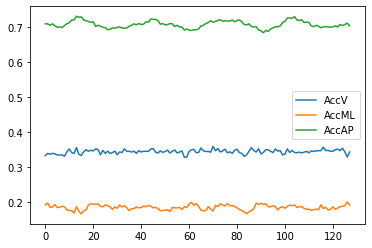

In [15]:
df[['AccV','AccML','AccAP']][0:128].plot()

In [16]:
x_win = []
y_win = []

x = df[['AccV','AccML','AccAP']]
y = df[['fog','normal']]

for i in range(0,len(df)-len(df)%256,128):
    x_win.append(x[i:i+256])
    y_win.append(y[i:i+256])
    
x_win.pop()
y_win.pop()
x_win = np.asarray(x_win,dtype = np.float32)
y_win = np.asarray(y_win,dtype = int)

In [17]:
from scipy import stats
y_win_s2l = []
for i in y_win:
    y_win_s2l.append(stats.mode(i)[0][0])
y_win_s2l = np.asarray(y_win_s2l,dtype = int)

In [18]:
x_win_aug = []
y_win_s2l_aug = []
for i in range(len(y_win_s2l)):
    x_win_aug.append(x_win[i])
    y_win_s2l_aug.append(y_win_s2l[i])
    
    if y_win_s2l[i,0]==1:
        x_win_aug.append(x_win[i])
        y_win_s2l_aug.append(y_win_s2l[i])
x_win_aug = np.asarray(x_win_aug,dtype = np.float32)
y_win_s2l_aug = np.asarray(y_win_s2l_aug,dtype = int)

In [19]:
# Importing Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization,Input,Bidirectional,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [20]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
        print(' - lr:',model.optimizer._decayed_lr(tf.float32).numpy(),' - Fold number:',k)

In [27]:
from sklearn.model_selection import KFold
import tensorflow_addons as tfa
from math import exp,cos
kfold = KFold(n_splits=5, shuffle=False)
models = []
evals = []
k = 0


In [28]:
# for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
#     x_train, x_val, y_train, y_val = train_test_split(x_win_aug[train], y_win_s2l_aug[train], test_size=0.10)

#     model = Sequential([
#         LSTM(50, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = True ),
#         Dropout(0.2),
#         LSTM(50, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
#         Dropout(0.2),
#         Dense(2, activation = 'softmax') 
#     ])
#     def scale_fn(x):return 1/(1.2**(x-1))
#     clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=10e-5,
#         maximal_learning_rate=10e-3,
#         scale_fn= scale_fn,
#         step_size= 204,
#         )
#     model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = clr),#, clipvalue=0.5),
#                     loss='categorical_crossentropy', 
#                     metrics=['accuracy'],
#                     )

    
#     earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
#     checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'best_{k}.hdf5', verbose=0, save_best_only=True,monitor='val_accuracy',mode='max')
#     csv_logger = tf.keras.callbacks.CSVLogger(f"history_log_{k}.csv")

#     model.fit(x_train, y_train, batch_size = 256, epochs = 500, callbacks = [earlystop,checkpointer,csv_logger,CustomCallback()],validation_data=(x_val,y_val))
#     model = tf.keras.models.load_model(f'best_{k}.hdf5', compile=False)
#     clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
#         maximal_learning_rate=1e-2,
#         scale_fn= scale_fn,
#         step_size= 204,
#         )
#     model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = clr, clipvalue=1),
#                     loss='categorical_crossentropy', 
#                     metrics=['accuracy'],
#                     )

#     models.append(model)
#     evals.append(model.evaluate(x_win_aug[test],y_win_s2l_aug[test]))
    
#     k+=1

In [29]:
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    if k in [0,1,2,3]:
        k+=1
        continue
    x_train, x_val, y_train, y_val = train_test_split(x_win_aug[train], y_win_s2l_aug[train], test_size=0.10)

    model = Sequential([
        LSTM(50, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = True ),
        Dropout(0.2),
        LSTM(50, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.L2(1e-4), input_shape=(256,3), return_sequences = False ),
        Dropout(0.2),
        Dense(2, activation = 'softmax') 
    ])
    def scale_fn(x):return 1/(1.2**(x-1))
    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=10e-5,
        maximal_learning_rate=10e-3,
        scale_fn= scale_fn,
        step_size= 204,
        )
    model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = clr),#, clipvalue=0.5),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'],
                    )

    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=25)
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'best_{k}.hdf5', verbose=0, save_best_only=True,monitor='val_accuracy',mode='max')
    csv_logger = tf.keras.callbacks.CSVLogger(f"history_log_{k}.csv")

    model.fit(x_train, y_train, batch_size = 256, epochs = 500, callbacks = [earlystop,checkpointer,csv_logger,CustomCallback()],validation_data=(x_val,y_val))
    model = tf.keras.models.load_model(f'best_{k}.hdf5', compile=False)
    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
        maximal_learning_rate=1e-2,
        scale_fn= scale_fn,
        step_size= 204,
        )
    model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = clr, clipvalue=1),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'],
                    )

    
    
    k+=1

Epoch 1/500
204/204 [==============================] - 18s 75ms/step - loss: 0.6344 - accuracy: 0.6461 - val_loss: 0.7298 - val_accuracy: 0.4876
Epoch 2/500
204/204 [==============================] - 13s 65ms/step - loss: 0.6794 - accuracy: 0.5541 - val_loss: 0.6665 - val_accuracy: 0.5544
Epoch 3/500
204/204 [==============================] - 14s 68ms/step - loss: 0.6582 - accuracy: 0.5815 - val_loss: 0.6661 - val_accuracy: 0.5788
Epoch 4/500
204/204 [==============================] - 12s 61ms/step - loss: 0.6620 - accuracy: 0.5609 - val_loss: 0.6558 - val_accuracy: 0.5931
Epoch 5/500
204/204 [==============================] - 14s 69ms/step - loss: 0.6544 - accuracy: 0.5732 - val_loss: 0.6786 - val_accuracy: 0.5226
Epoch 6/500
204/204 [==============================] - 13s 65ms/step - loss: 0.6884 - accuracy: 0.5244 - val_loss: 0.7054 - val_accuracy: 0.5226
Epoch 7/500
204/204 [==============================] - 13s 64ms/step - loss: 0.7033 - accuracy: 0.5140 - val_loss: 0.7005 - val_ac

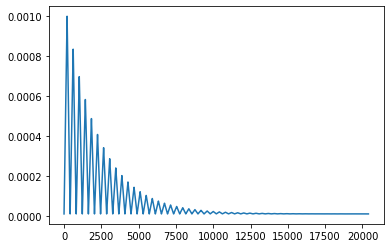

In [30]:
def scale_fn(x):return 1/(1.2**(x-1))
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
        maximal_learning_rate=1e-3,
        scale_fn= scale_fn,
        step_size= 204,
        )
step = range(0, 100 * 204)
lr = clr(step)
plt.plot(step, lr)

In [33]:
import tensorflow_addons as tfa
# x_win_aug[test],y_win_s2l_aug[test]
f1 = []
recalls = []
precisions = []
k = 0
kfold = KFold(n_splits=5, shuffle=False)
models = []
evals = []
for train, test in kfold.split(x_win_aug, y_win_s2l_aug):
    model = tf.keras.models.load_model(f'best_{k}.hdf5', compile=False)
    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
        maximal_learning_rate=1e-2,
        scale_fn= scale_fn,
        step_size= 204,
        )
    model.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = clr, clipvalue=1),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'],
                    )

    models.append(model)
    evals.append(model.evaluate(x_win_aug[test],y_win_s2l_aug[test]))
    metric = tfa.metrics.F1Score(num_classes=2,threshold=0.5)

    y_true = y_win_s2l_aug[test]
    y_pred = models[k].predict(x_win_aug[test])

    recall = tf.keras.metrics.Recall()
    recall.update_state(y_true, y_pred)
    recalls.append(recall.result().numpy())
    
    precision = tf.keras.metrics.Precision()
    precision.update_state(y_true, y_pred)
    precisions.append(precision.result().numpy())
    k+=1
f1 = 2 * (np.array(precisions) * np.array(recalls)) / (np.array(precisions) + np.array(recalls))

452/452 [==============================] - 10s 21ms/step


In [34]:
import pickle
file1 = open('evaluations', 'wb')
file2 = open('models', 'wb')
file3 = open('scores', 'wb')
pickle.dump(evals, file1)
pickle.dump (models, file2)
pickle.dump([f1,recalls,precisions], file3)
file1.close()
file2.close()
file3.close()

INFO:tensorflow:Assets written to: ram://78929ea2-5376-4d7f-b488-a18a06036aad/assets


INFO:tensorflow:Assets written to: ram://78929ea2-5376-4d7f-b488-a18a06036aad/assets


INFO:tensorflow:Assets written to: ram://d3178aa7-233d-4b64-8967-ffd3c85af498/assets


INFO:tensorflow:Assets written to: ram://d3178aa7-233d-4b64-8967-ffd3c85af498/assets


INFO:tensorflow:Assets written to: ram://2a125bb5-96a3-4246-8238-233d091697dd/assets


INFO:tensorflow:Assets written to: ram://2a125bb5-96a3-4246-8238-233d091697dd/assets


INFO:tensorflow:Assets written to: ram://ef4985ad-accb-4591-bdd3-37bbf69ceba4/assets


INFO:tensorflow:Assets written to: ram://ef4985ad-accb-4591-bdd3-37bbf69ceba4/assets


INFO:tensorflow:Assets written to: ram://f6af9165-4db5-4f4e-8a02-da876d4b0358/assets


INFO:tensorflow:Assets written to: ram://f6af9165-4db5-4f4e-8a02-da876d4b0358/assets
